<a href="https://colab.research.google.com/github/Ananassio/Data-Science_lab/blob/main/Project/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A first look at the data

In [214]:
#get data from server
!wget --no-check-certificate https://www.keuper-labs.org/project_ss22.zip

--2022-05-22 11:35:52--  https://www.keuper-labs.org/project_ss22.zip
Resolving www.keuper-labs.org (www.keuper-labs.org)... 91.250.118.129
Connecting to www.keuper-labs.org (www.keuper-labs.org)|91.250.118.129|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 70859177 (68M) [application/zip]
Saving to: ‘project_ss22.zip.1’

project_ss22.zip.1  100%[===================>]  67.58M  11.4MB/s    in 6.4s    

2022-05-22 11:35:59 (10.5 MB/s) - ‘project_ss22.zip.1’ saved [70859177/70859177]



In [215]:
#unpack
!unzip project_ss22.zip

Archive:  project_ss22.zip
replace dressipi_recsys2022/candidate_items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [216]:
#Importieren der nötigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [277]:
# Importieren und zuweisung der Daten
items = pd.read_csv('dressipi_recsys2022/candidate_items.csv')
features = pd.read_csv('dressipi_recsys2022/item_features.csv')
train_purchases = pd.read_csv('dressipi_recsys2022/train_purchases.csv')
train_sessions = pd.read_csv('dressipi_recsys2022/train_sessions.csv')
test_leaderboard_sessions = pd.read_csv('dressipi_recsys2022/test_leaderboard_sessions.csv')

## have a first look



---


Hier werden zunächst die Datensätze einmal ausgegebn, um einen Überblick 
zubekommen wie diese aufgebaut sind.

In dem items Datensatz sind die item ids, welche in bei den testsessions gekauft wurden 

In [218]:
items

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [219]:
#how many items do we have?
items.describe()

,item_id
count,4990.000000
mean,14007.035271
std,8218.231425
min,4.000000
25%,6833.500000
50%,14108.500000
75%,21200.000000
max,28137.000000




---


In dem features Dataset sind die entsprechenden item features der jeweiligen items aufgelistet. Dabei werden die feature Kategorien wie Farbe, Ausschnitt, etc mit einer value id z.B. grün beschrieben. Die einzelnen items haben mehrere Kategorien, welche die items beschreiben, siehe hier z.B. item 2 hat 13 feature Kategorien.

In [278]:
features

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [291]:
features.describe()

,item_id,feature_category_id,feature_value_id
count,471751.000000,471751.000000,471751.000000
mean,14058.539477,42.424597,486.345578
std,8107.465455,22.186285,258.865151
min,2.000000,1.000000,1.000000
25%,7060.000000,25.000000,273.000000
50%,14045.000000,47.000000,512.000000
75%,21063.000000,61.000000,708.000000
max,28143.000000,73.000000,905.000000




---


Der Train_purchases Datensatz beinhaltet eine item id, welche am Ende der jeweiligen session letzlich gekauft wurde. Zusätzlich gibt es dabei noch einen Zeitstempel.
Die gesamten Daten wurden in einem Zeitraum von 18 Monaten aufgezeichnet, dabei wurden Daten der ersten 17 Monate für den Trainingsdatensatz verwendet und der letzte Monat wurde für den Testdatensatz verwendet.

In [222]:
train_purchases.head()

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114




---


In dem Datensatz train_session sind die item ids aufgelistet, welche innerhalb einer session angesehen wurden. Auch hier gibt es jeweils einen Zeitstempel.

In [223]:
train_sessions.head()

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211




---


Auf den Daten des Datensatzes test_leaderboard_session sollen die Vorhersagen für die Bestenliste des Wettbewerbs getätigt werden. 

In [224]:
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


Um die features nutzbar zu machen, soll der Datensatz in einer Tabelle mit der item_id als index und die feature_category_ids als spalten dargestellt werde.
Allerdings gibt esin dem features Dataframe doppelte Einträge, wodurch die pivot funktion nicht direkt angewendet werden kann. 
(Damit der code an einem Stück durchlaufen kann, wurde hierfür ein Screenshot der Fehlermelung eingefügt)
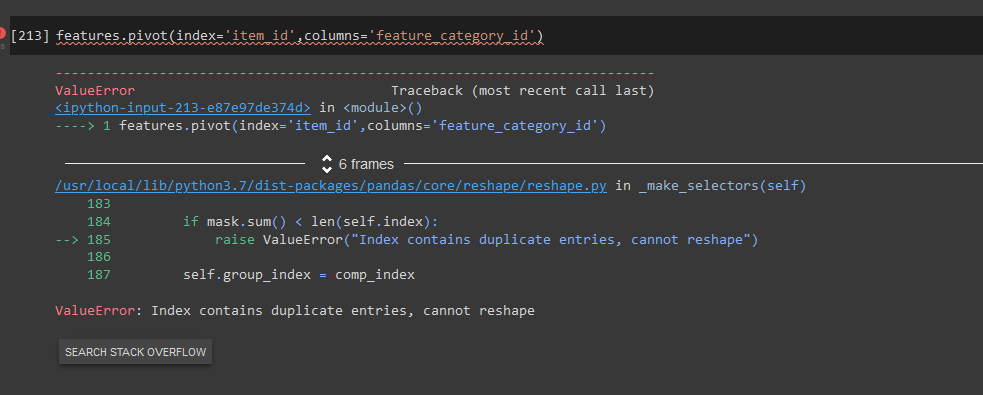

## Finden der doppelten feature_category_ids

In [225]:
#search for the duplicated feature_ids in the features DataFrame
# first drop the feature_value_id so that the duplicated feature_ids can be found
a = features.drop(['feature_value_id'],axis=1)

for i in a['feature_category_id'].unique():
  if a[a['feature_category_id']== i].duplicated().sum() > 0:
    print(i)

53
46
4
30
28
1


In [280]:
 #check if the duplicates are correct
 features[features['feature_category_id'] == 30]#.head()

,item_id,feature_category_id,feature_value_id
129,10,30,564
134,10,30,482
153,11,30,847
154,11,30,478
156,11,30,715
...,...,...,...
471557,28133,30,482
471561,28133,30,194
471590,28135,30,564
471593,28135,30,478


In [301]:
nums = features[features['feature_category_id'] == 30]['item_id'].value_counts()
nums

24947    8
7970     8
26951    7
4585     7
16345    7
        ..
7496     1
3111     1
23727    1
15054    1
3286     1
Name: item_id, Length: 5683, dtype: int64

In [302]:
nums[24947]

8

In [308]:
features[features[features['item_id'] == 24947]['feature_category_id']== 30]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


IndexingError: ignored

In [298]:
(482<<(7*12)| 715<<(6*12) | 271<< (5*12) | 360 << (4*12) | 194 << (3*12) | 435 << (2*12) | 478 << (1*12) | 466<<(0*12))

'0b111100010001011001011000100001111000101101000000011000010000110110011000111011110000111010010'

In [296]:
bin(478) dez()

'0b111011110'

In [227]:
#first drop the duplicated to che if now no mare duplicates are here
c = features.drop(features[features['feature_category_id'] == 30].index)
c = c.drop(c[c['feature_category_id'] == 53].index)
c = c.drop(c[c['feature_category_id'] == 46].index)
c = c.drop(c[c['feature_category_id'] == 4].index)
c = c.drop(c[c['feature_category_id'] == 28].index)
c = c.drop(c[c['feature_category_id'] == 1].index)

Mit dem entfernen der feature_value_ids mit doppeltem vorkommen lässt sich nun die pivot function anwenden. Allerdings könnten so wichtige Eigenschaften, wie z.B. die Farben der Items nicht berücksichtigt sein.

In [228]:
#now the pivot function works, but 6 feature_category_ids are dropped
c.pivot(index='item_id',columns='feature_category_id')

feature_value_id                                       \
feature_category_id               2      3      5   6      7   8   9   10   
item_id                                                                     
2                                NaN    NaN    NaN NaN  394.0 NaN NaN NaN   
3                                NaN  889.0  605.0 NaN  452.0 NaN NaN NaN   
4                                NaN  793.0  605.0 NaN  837.0 NaN NaN NaN   
7                                NaN    NaN    NaN NaN  536.0 NaN NaN NaN   
8                                NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
...                              ...    ...    ...  ..    ...  ..  ..  ..   
28139                            NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
28140                           53.0    NaN    NaN NaN    NaN NaN NaN NaN   
28141                            NaN  889.0  605.0 NaN    2.0 NaN NaN NaN   
28142                            NaN    NaN    NaN NaN  619.0 NaN NaN NaN   
28143                            NaN    NaN    NaN NaN  798.0 NaN NaN NaN   

                                ...                                            \
feature_category_id     11  12  ...    64     65  66     67     68     69  70   
item_id                         ...                                             
2                      NaN NaN  ...   NaN    NaN NaN    NaN  351.0  885.0 NaN   
3                    859.0 NaN  ...   NaN  521.0 NaN    NaN   14.0  592.0 NaN   
4                      NaN NaN  ...   NaN  521.0 NaN    NaN  373.0  538.0 NaN   
7                      NaN NaN  ...   NaN    NaN NaN    NaN  739.0  592.0 NaN   
8                    735.0 NaN  ...   NaN  521.0 NaN    NaN  351.0  592.0 NaN   
...                    ...  ..  ...   ...    ...  ..    ...    ...    ...  ..   
28139                  NaN NaN  ...   NaN  521.0 NaN    NaN  106.0  805.0 NaN   
28140                  NaN NaN  ...  80.0    NaN NaN  349.0  351.0    NaN NaN   
28141                  NaN NaN  ...   NaN    NaN NaN    NaN  379.0  499.0 NaN   
28142                  NaN NaN  ...   NaN  610.0 NaN    NaN  895.0  740.0 NaN   
28143                109.0 NaN  ...   NaN    NaN NaN    NaN  351.0  499.0 NaN   

                                          
feature_category_id     71     72     73  
item_id                                   
2                      NaN   75.0    NaN  
3                      NaN   75.0  544.0  
4                      NaN   75.0  544.0  
7                      NaN   75.0    NaN  
8                      NaN   75.0  544.0  
...                    ...    ...    ...  
28139                  NaN   75.0  544.0  
28140                226.0    NaN  544.0  
28141                  NaN   75.0  544.0  
28142                  NaN   75.0   91.0  
28143                  NaN  371.0   91.0  

[23691 rows x 67 columns]

Eine andere Möglichkeit wäre die Funktion pivot_table, hier werden allerdings die doppelten Werte z.B. auf summiert oder deren Mittelwert gebildet, was auch zu einer verfälschung der Werte führt. Damit wären keine logischen zusammenhänge mehr möglich.


In [229]:
features.pivot_table(index='item_id',columns='feature_category_id',  fill_value=0)

feature_value_id                                        \
feature_category_id               1   2    3      4    5  6    7  8  9  10   
item_id                                                                      
2                                  0   0    0    0.0    0  0  394  0  0  0   
3                                  0   0  889  618.0  605  0  452  0  0  0   
4                                  0   0  793  618.0  605  0  837  0  0  0   
7                                  0   0    0    0.0    0  0  536  0  0  0   
8                                  0   0  793  618.0  605  0  798  0  0  0   
...                              ...  ..  ...    ...  ... ..  ... .. .. ..   
28139                              0   0  793  618.0  605  0  798  0  0  0   
28140                              0  53    0    0.0    0  0    0  0  0  0   
28141                            461   0  889  719.0  605  0    2  0  0  0   
28142                              0   0    0    0.0    0  0  619  0  0  0   
28143                              0   0    0    0.0    0  0  798  0  0  0   

                     ...                                               
feature_category_id  ...  64   65 66   67   68   69 70   71   72   73  
item_id              ...                                               
2                    ...   0    0  0    0  351  885  0    0   75    0  
3                    ...   0  521  0    0   14  592  0    0   75  544  
4                    ...   0  521  0    0  373  538  0    0   75  544  
7                    ...   0    0  0    0  739  592  0    0   75    0  
8                    ...   0  521  0    0  351  592  0    0   75  544  
...                  ...  ..  ... ..  ...  ...  ... ..  ...  ...  ...  
28139                ...   0  521  0    0  106  805  0    0   75  544  
28140                ...  80    0  0  349  351    0  0  226    0  544  
28141                ...   0    0  0    0  379  499  0    0   75  544  
28142                ...   0  610  0    0  895  740  0    0   75   91  
28143                ...   0    0  0    0  351  499  0    0  371   91  

[23691 rows x 73 columns]

Aus den genannten Gründen werden die doppelten value_ids binärzusammengefasst.

In [256]:
features[features['feature_category_id'] == 4].describe()

,item_id,feature_category_id,feature_value_id
count,14954.000000,14954.0,14954.000000
mean,14032.217801,4.0,608.258058
std,8133.800410,0.0,85.961140
min,3.000000,4.0,214.000000
25%,6983.250000,4.0,618.000000
50%,13978.000000,4.0,618.000000
75%,21112.750000,4.0,618.000000
max,28141.000000,4.0,865.000000


In [274]:
q = features
q.iloc[0,2] = bin(9|10<<12)
q

,item_id,feature_category_id,feature_value_id,"(0, feature_value_id)"
0,2,56,0b1010000000001001,0b1001
1,2,62,801,0b1001
2,2,68,351,0b1001
3,2,33,802,0b1001
4,2,72,75,0b1001
...,...,...,...,...
471746,28143,68,351,0b1001
471747,28143,55,390,0b1001
471748,28143,11,109,0b1001
471749,28143,73,91,0b1001


In [279]:
features[features['feature_category_id'] == 53]

,item_id,feature_category_id,feature_value_id
9,2,53,6
174,13,53,6
262,19,53,707
306,21,53,444
388,28,53,707
...,...,...,...
471256,28114,53,444
471331,28120,53,6
471556,28133,53,444
471594,28135,53,444


# Erstellen eines Testscores mit zufälligen ergebnissen

Erstellen eines Zufälligen Testscores mit je 100 zufälligen Item ids pro Session. Die item ids werden hierfür aus der items liste entnommen.

In [233]:
test = pd.DataFrame();

In [234]:
test['session_id'] = test_leaderboard_sessions['session_id'].unique()
test  = test.loc[test.index.repeat(100)].reset_index(drop=True)
test['item_id'] = pd.DataFrame(np.random.randint(items['item_id'].min(), items['item_id'].max(), size=(len(test),1)))
test['rank'] = test.groupby('session_id').cumcount()+1
test = test.set_index('session_id')


In [235]:
test.head(102)

,item_id,rank
session_id,,
26,10419,1
26,9092,2
26,5886,3
26,2776,4
26,24537,5
...,...,...
26,20811,98
26,5452,99
26,9095,100


In [236]:
test.to_csv('test.csv')

### Lets take a closer look to the test_leaderboard_seesions

In [237]:
# first count the ammount of the session numbers
A = pd.DataFrame(test_leaderboard_sessions['session_id'].value_counts().sort_values())['session_id'].value_counts()

In [238]:
A.to_frame()

,session_id
1,17036
2,7994
3,5444
4,3766
5,2844
...,...
60,1
61,1
55,1
53,1


In [239]:
# lets use the describe function for better analysing of the numbers 
test_leaderboard_sessions['session_id'].value_counts().sort_values().describe()

count    50000.000000
mean         4.587080
std          5.666023
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max         72.000000
Name: session_id, dtype: float64

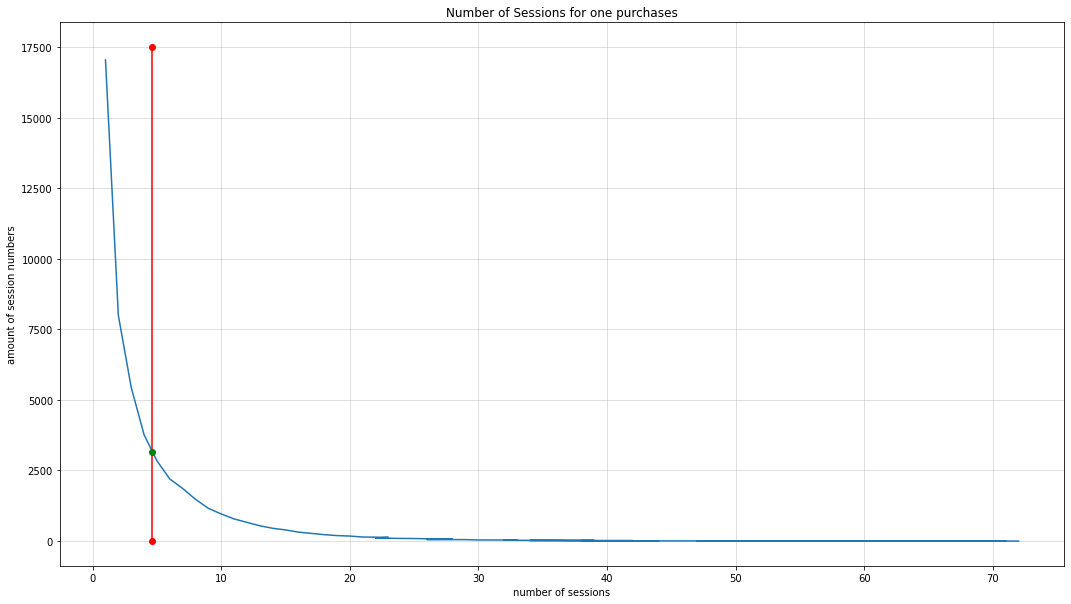

In [240]:

# print the generated curve of the session ammounts
fig, axes = plt.subplots(figsize=(18,10))

axes.plot(A)
axes.plot([4.58708,4.58708], [0,17500], '-ro', label='line & marker')
axes.plot(4.58708,3150, 'go', label='marker only')
axes.set_xlabel('number of sessions')
axes.set_ylabel('amount of session numbers')
axes.set_title('Number of Sessions for one purchases');
axes.grid(alpha=0.5)

Da in den meisten sessions nur ein item angesehen wird, werden als nächstes die ids vorgeschlagen, wechle zuletzt in der Session angesehen wurden.

In [241]:
test2 = pd.DataFrame();

In [242]:
#test2['session_id'] = test_leaderboard_sessions['session_id'].unique();
idx = test_leaderboard_sessions.groupby(['session_id'])['date'].transform(max) == test_leaderboard_sessions['date']

In [243]:
test2 = test_leaderboard_sessions[idx]

In [244]:
test2 = test2.reset_index()

In [245]:
test2['session_id']

0             26
1            200
2            205
3            495
4            521
          ...   
50001    4439446
50002    4439458
50003    4439550
50004    4439653
50005    4439757
Name: session_id, Length: 50006, dtype: int64

In [246]:
test2

,index,session_id,item_id,date
0,0,26,19185,2021-06-16 09:53:54.158
1,4,200,4758,2021-06-25 12:24:50.692
2,5,205,8194,2021-06-11 00:28:07.058
3,6,495,6853,2021-06-14 22:13:06.741
4,7,521,26471,2021-06-19 13:50:03.09
...,...,...,...,...
50001,229337,4439446,21396,2021-06-11 17:17:11.565
50002,229339,4439458,26499,2021-06-09 04:54:45.378
50003,229340,4439550,19086,2021-06-02 17:42:40.481
50004,229350,4439653,12179,2021-06-11 10:23:00.663


In [247]:
test_leaderboard_sessions.head(20)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
5,205,8194,2021-06-11 00:28:07.058
6,495,6853,2021-06-14 22:13:06.741
7,521,26471,2021-06-19 13:50:03.09
8,587,22204,2021-06-01 16:43:22.80
9,721,13914,2021-06-19 18:46:57.263


In [248]:
a = test2['session_id'].duplicated() == test2['session_id']

In [249]:
a

0        False
1        False
2        False
3        False
4        False
         ...  
50001    False
50002    False
50003    False
50004    False
50005    False
Name: session_id, Length: 50006, dtype: bool

In [250]:
test3  = pd.DataFrame()

In [251]:
test3['session_id'] = test_leaderboard_sessions['session_id'].unique()
test3['item_id'] = test2['item_id']
test3['rank'] = 1
test3 = test3.set_index('session_id')

In [252]:
test3

,item_id,rank
session_id,,
26,19185,1
200,4758,1
205,8194,1
495,6853,1
521,26471,1
...,...,...
4439446,26054,1
4439458,7664,1
4439550,23038,1


In [253]:
test3.to_csv('test3.csv')